In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import keras
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16

%reload_ext autoreload
%autoreload 2
from utils import *

In [2]:
train_df = pd.read_csv('../data/train_df.csv', index_col=0)
train_df.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target,gen_enc,site_enc,diag_enc
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0,1,0,8
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0,0,6,8
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0,0,1,5
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0,0,0,8
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0,0,6,8


In [3]:
train = pd.read_csv('../data/train.csv', index_col=0)
train.head()

,file,target
0,ISIC_1569119,1
1,ISIC_7536704,1
2,ISIC_3696488,1
3,ISIC_3343475,1
4,ISIC_7785723,1


In [4]:
train_2 = train.merge(train_df, how='left', on='file')
train_2 = train_2.drop(columns=['target_x'], axis=1)
train_2 = train_2.rename(columns={'target_y': 'target'})
train_2.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target,gen_enc,site_enc,diag_enc
0,ISIC_1569119,IP_6120178,IL_3157235,male,65.0,torso,melanoma,malignant,1,1,4,4
1,ISIC_7536704,IP_3994607,IL_1685088,male,75.0,torso,melanoma,malignant,1,1,4,4
2,ISIC_3696488,IP_6051587,IL_8878499,female,90.0,upper extremity,melanoma,malignant,1,0,6,4
3,ISIC_3343475,IP_4576785,IL_9262145,male,80.0,head/neck,melanoma,malignant,1,1,0,4
4,ISIC_7785723,IP_8447624,IL_2711936,female,50.0,lower extremity,melanoma,malignant,1,0,1,4


In [5]:
train_2.to_csv('../data/train_2.csv')

In [6]:
val = pd.read_csv('../data/val.csv', index_col=0)
val.head()

,file,target
0,ISIC_6767569,1
1,ISIC_7312977,1
2,ISIC_1785627,1
3,ISIC_8066110,1
4,ISIC_8838753,1


In [7]:
val_2 = val.merge(train_df, how='left', on='file')
val_2 = val_2.drop(columns=['target_x'], axis=1)
val_2 = val_2.rename(columns={'target_y': 'target'})
val_2.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target,gen_enc,site_enc,diag_enc
0,ISIC_6767569,IP_7665112,IL_1769376,male,70.0,head/neck,melanoma,malignant,1,1,0,4
1,ISIC_7312977,IP_8675890,IL_2723500,male,55.0,lower extremity,melanoma,malignant,1,1,1,4
2,ISIC_1785627,IP_0170821,IL_6029631,female,40.0,upper extremity,melanoma,malignant,1,0,6,4
3,ISIC_8066110,IP_3055814,IL_7066374,male,50.0,lower extremity,melanoma,malignant,1,1,1,4
4,ISIC_8838753,IP_6292815,IL_9486623,female,65.0,lower extremity,melanoma,malignant,1,0,1,4


In [8]:
val_2.to_csv('../data/val_2.csv')

In [9]:
test = pd.read_csv('../data/test_df.csv', index_col=0)
test.head()

,file,age,site,lesion_id,gender,target,jpg
0,ISIC_0000000,55.0,anterior torso,NaN,female,0,ISIC_0000000.jpg
1,ISIC_0000001,30.0,anterior torso,NaN,female,0,ISIC_0000001.jpg
2,ISIC_0000002,60.0,upper extremity,NaN,female,1,ISIC_0000002.jpg
3,ISIC_0000003,30.0,upper extremity,NaN,male,0,ISIC_0000003.jpg
4,ISIC_0000004,80.0,posterior torso,NaN,male,1,ISIC_0000004.jpg


# ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [11]:
train_folder = '../split/train'
val_folder = '../split/val'
test_folder = '../split/test2'

In [12]:
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 32,
                                                    class_mode = 'binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 32,
                                                                       class_mode = 'binary')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 32,
                                                                        class_mode = 'binary')

Found 32135 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


# Baseline CNN Model

In [15]:
def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=4096, activation='softmax'),
        layers.Dense(units=1, activation='sigmoid')
        ])
        # sigmoid also

model = create_model((224, 224, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')],
              run_eagerly = True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 128)    

In [19]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              verbose = 1,
                              epochs = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              validation_steps = 20)

Epoch 1/5
20/20 [==============================] - 1303s 65s/step - loss: 0.4956 - accuracy: 0.8250 - precision: 0.8250 - recall: 1.0000 - auc: 0.7100 - auc_1: 0.9269 - val_loss: 0.3787 - val_accuracy: 0.9875 - val_precision: 0.9875 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9875
Epoch 2/5
20/20 [==============================] - 1246s 61s/step - loss: 0.4719 - accuracy: 0.8125 - precision: 0.8125 - recall: 1.0000 - auc: 0.7631 - auc_1: 0.9321 - val_loss: 0.3636 - val_accuracy: 0.9828 - val_precision: 0.9828 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9828
Epoch 3/5
20/20 [==============================] - 1394s 69s/step - loss: 0.4597 - accuracy: 0.8078 - precision: 0.8078 - recall: 1.0000 - auc: 0.7324 - auc_1: 0.9123 - val_loss: 0.3564 - val_accuracy: 0.9844 - val_precision: 0.9844 - val_recall: 1.0000 - val_auc: 0.5008 - val_auc_1: 0.9845
Epoch 4/5
20/20 [==============================] - 1046s 51s/step - loss: 0.4237 - accuracy: 0.8297 - precision: 0.8297 - re

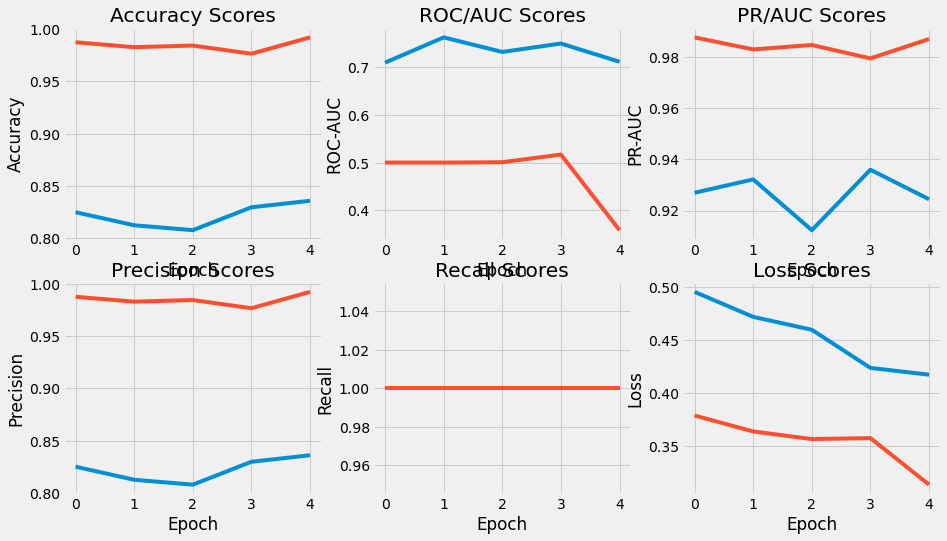

In [29]:
plt.style.use('fivethirtyeight')
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [29]:
test_x, test_y = next(test_generator)
train_x, train_y = next(train_generator)
val_x, val_y = next(val_generator)

In [31]:
results_train

[0.5641394853591919, 0.75, 0.75, 1.0, 0.5, 0.75]

In [33]:
results_val

[0.29310697317123413, 0.96875, 0.96875, 1.0, 0.5, 0.96875]

In [27]:
results_test

[0.3318259119987488, 0.9375, 0.9375, 1.0, 0.5, 0.9375]

# Transfer Learning

In [71]:
base_model = applications.resnet50.ResNet50(include_top=False, input_shape=(256, 256, 3), weights="imagenet")
base_model.trainable = False

model = models.Sequential([
        base_model,
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='softmax'),
])

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])


In [73]:
history_3 = model.fit(train_generator, 
                      epochs = 5,
                      steps_per_epoch = 20,
                      validation_data = val_generator,
                      validation_steps = 20)

Epoch 1/5
20/20 [==============================] - 284s 14s/step - loss: 0.5788 - accuracy: 0.7953 - precision_11: 0.7953 - recall_11: 1.0000 - auc_22: 0.5000 - auc_23: 0.7953 - val_loss: 0.4615 - val_accuracy: 0.9766 - val_precision_11: 0.9766 - val_recall_11: 1.0000 - val_auc_22: 0.5000 - val_auc_23: 0.9766
Epoch 2/5
20/20 [==============================] - 272s 14s/step - loss: 0.5537 - accuracy: 0.8000 - precision_11: 0.8000 - recall_11: 1.0000 - auc_22: 0.5000 - auc_23: 0.8000 - val_loss: 0.4186 - val_accuracy: 0.9797 - val_precision_11: 0.9797 - val_recall_11: 1.0000 - val_auc_22: 0.5000 - val_auc_23: 0.9797
Epoch 3/5
20/20 [==============================] - 301s 15s/step - loss: 0.5315 - accuracy: 0.8078 - precision_11: 0.8078 - recall_11: 1.0000 - auc_22: 0.5000 - auc_23: 0.8078 - val_loss: 0.3834 - val_accuracy: 0.9812 - val_precision_11: 0.9812 - val_recall_11: 1.0000 - val_auc_22: 0.5000 - val_auc_23: 0.9812
Epoch 4/5
20/20 [==============================] - 317s 16s/step - 

Text(0.5, 1.0, 'PR-AUC Scores')

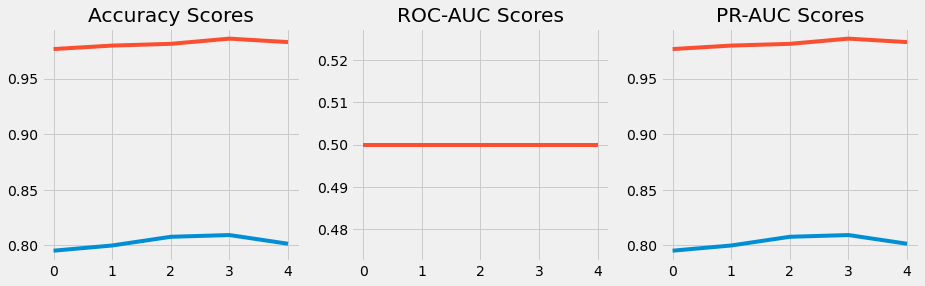

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
ax1.plot(history_3.history['accuracy'])
ax1.plot(history_3.history['val_accuracy'])
ax2.plot(history_3.history['auc_22'])
ax2.plot(history_3.history['val_auc_22'])
ax3.plot(history_3.history['auc_23'])
ax3.plot(history_3.history['val_auc_23']) 
ax1.set_title('Accuracy Scores')
ax2.set_title('ROC-AUC Scores')
ax3.set_title('PR-AUC Scores')

# ResNet Base

In [86]:
base_model = keras.applications.ResNet50(weights= None, include_top=False, input_shape= (256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [87]:
# y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
# y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

history_4 = model.fit(train_generator, 
                      epochs = 5,
                      steps_per_epoch = 20,
                      validation_data = val_generator,
                      validation_steps = 20)

Epoch 1/5


ValueError: in user code:

    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


# VGG16

In [88]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(inputs=input_, outputs=last_layer)

model.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [89]:
history5 = model.fit(train_generator,
                     epochs = 5,
                     steps_per_epoch = 20,
                     verbose = 1,
                     validation_data = val_generator,
                     validation_steps = 20)

Epoch 1/5
20/20 [==============================] - 628s 32s/step - loss: 2.7157 - accuracy: 0.7504 - precision_13: 0.8185 - recall_13: 0.8744 - auc_26: 0.6039 - auc_27: 0.8218 - val_loss: 1.1507 - val_accuracy: 0.7281 - val_precision_13: 0.9956 - val_recall_13: 0.7248 - val_auc_26: 0.8446 - val_auc_27: 0.9958
Epoch 2/5
20/20 [==============================] - 626s 32s/step - loss: 0.5546 - accuracy: 0.8645 - precision_13: 0.9333 - recall_13: 0.8972 - auc_26: 0.8765 - auc_27: 0.9556 - val_loss: 0.4810 - val_accuracy: 0.8844 - val_precision_13: 0.9859 - val_recall_13: 0.8946 - val_auc_26: 0.7266 - val_auc_27: 0.9895
Epoch 3/5
20/20 [==============================] - 423s 21s/step - loss: 0.6827 - accuracy: 0.8805 - precision_13: 0.9125 - recall_13: 0.9385 - auc_26: 0.8492 - auc_27: 0.9299 - val_loss: 0.2004 - val_accuracy: 0.9453 - val_precision_13: 0.9804 - val_recall_13: 0.9631 - val_auc_26: 0.7591 - val_auc_27: 0.9892
Epoch 4/5
19/20 [===========================>..] - ETA: 9s - loss: 

UnknownError:  OSError: image file is truncated (5 bytes not processed)
Traceback (most recent call last):

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/Image.py", line 1916, in resize
    self.load()

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/ImageFile.py", line 260, in load
    "image file is truncated "

OSError: image file is truncated (5 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_182175]

Function call stack:
train_function


In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.plot(history.history['auc_5'])
plt.plot(history.history['val_auc_5'])
plt.title('Model Metrics')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()